In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from boruta import BorutaPy
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
ordinal = pd.read_csv('ordinal.csv')
drop = pd.read_csv('drop.csv')
full = pd.read_csv('full.csv')

In [3]:
ordinal_X = ordinal.drop(columns=['SalePrice'])
ordinal_y = np.log(ordinal['SalePrice'])
drop_X = drop.drop(columns=['SalePrice'])
drop_y = np.log(drop['SalePrice'])
full_X = full.drop(columns=['SalePrice'])
full_y = np.log(full['SalePrice'])

### Split the data into Training and Testing Datasets

In [4]:
ordinal_train_X,ordinal_test_x,ordinal_train_y,ordinal_test_y = train_test_split(ordinal_X,ordinal_y,test_size=0.1,random_state=21)
drop_train_X,drop_test_x, drop_train_y,drop_test_y = train_test_split(drop_X,drop_y,test_size=0.1,random_state=21)
full_train_X,full_test_x,full_train_y,full_test_y = train_test_split(full_X,full_y,test_size=0.1,random_state=21)

### Test if the datasets are divided in the same way

In [5]:
(drop_test_y.mean() == full_test_y.mean())

True

### See if the samples for the Training and the Test set have similar propoerties and are aproptiate to use

Mean Sale Price for Training set:  12.022047312634376
STD for Sale Price for Training set:  0.39861960561966747


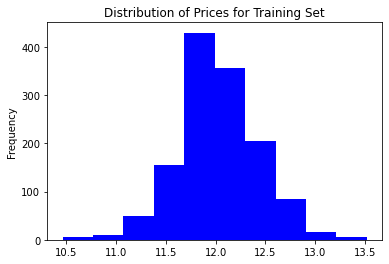

In [6]:
ordinal_train_y.plot(kind='hist',color='blue');
print('Mean Sale Price for Training set: ', ordinal_train_y.mean())
print('STD for Sale Price for Training set: ', ordinal_train_y.std())
plt.title('Distribution of Prices for Training Set');


Mean Sale Price for Test set:  12.042083197384516
STD for Sale Price for Test set:  0.40781482071890196


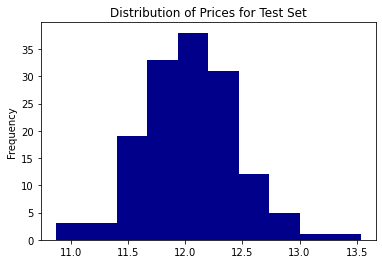

In [7]:
ordinal_test_y.plot(kind='hist',color='darkblue');
print('Mean Sale Price for Test set: ', ordinal_test_y.mean())
print('STD for Sale Price for Test set: ', ordinal_test_y.std())
plt.title('Distribution of Prices for Test Set');


In [8]:
from scipy.stats import ks_2samp
from scipy import stats
print(ks_2samp(ordinal_test_y,ordinal_train_y))
stats.ttest_ind(ordinal_test_y,ordinal_train_y)

KstestResult(statistic=0.060882800608828, pvalue=0.6963386570310459)


Ttest_indResult(statistic=0.5748335059148213, pvalue=0.5654925900791952)

### Dummy Regressor with Mean and Median

In [9]:
dumreg = DummyRegressor(strategy='mean')
dumreg_median = DummyRegressor(strategy='median')
dumreg.fit(ordinal_train_X,ordinal_train_y)
dumreg_median.fit(ordinal_train_X,ordinal_train_y)
pred_dummy = dumreg.predict(ordinal_train_X)
pred_dummy_median = dumreg_median.predict(ordinal_train_X)
print('Mean for Training Sample: ',round(ordinal_train_y.mean(),4))
print('STD for Training Sample: ',round(ordinal_train_y.std(),4))
print('Squared Error with Mean Predictor is: ', round(np.sqrt(mean_squared_error(pred_dummy,ordinal_train_y)),4))
print('Absolute Error with Mean Predictor is: ', round(mean_absolute_error(pred_dummy,ordinal_train_y),4))
print('Squared Error with Median Predictor is: ', round(np.sqrt(mean_squared_error(pred_dummy_median,ordinal_train_y)),4))
print('Absolute Error with Median Predictor is: ', round(mean_absolute_error(pred_dummy_median,ordinal_train_y),4))

Mean for Training Sample:  12.022
STD for Training Sample:  0.3986
Squared Error with Mean Predictor is:  0.3985
Absolute Error with Mean Predictor is:  0.3096
Squared Error with Median Predictor is:  0.399
Absolute Error with Median Predictor is:  0.3092


### We will test SGD on the Ordinal and Full Dataset 

#### SGD withouth parameter tuning

In [10]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
linreg = SGDRegressor()
scores_ordinal = cross_val_score(linreg, ordinal_train_X,ordinal_train_y,scoring='neg_mean_squared_error',cv=10)
scores_drop = cross_val_score(linreg, drop_train_X,drop_train_y,scoring='neg_mean_squared_error',cv=10)
scores_full = cross_val_score(linreg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)

In [11]:
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_ordinal.mean()),2))
print('Average Prediction Mistake for Drop Dataset: ', round(np.sqrt(-scores_drop.mean()),2))
print('Average Prediction Mistake for Full Dataset: ', round(np.sqrt(-scores_full.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.36
Average Prediction Mistake for Drop Dataset:  0.33
Average Prediction Mistake for Full Dataset:  0.24


In [12]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty': ('l1','l2'), 'alpha': np.linspace(0.01,5,10)}
sgd = SGDRegressor(loss='squared_loss')
gridsearch = GridSearchCV(sgd,parameters,cv=10,scoring='neg_mean_squared_error')
gridsearch.fit(drop_train_X,drop_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.3928012936159875 {'alpha': 0.01, 'penalty': 'l1'}
0.33778182444673777 {'alpha': 0.01, 'penalty': 'l2'}
0.39876904536674157 {'alpha': 0.5644444444444445, 'penalty': 'l1'}
0.22750114593422646 {'alpha': 0.5644444444444445, 'penalty': 'l2'}
0.3986300592784356 {'alpha': 1.118888888888889, 'penalty': 'l1'}
0.1893907115552508 {'alpha': 1.118888888888889, 'penalty': 'l2'}
0.3989243610459163 {'alpha': 1.6733333333333336, 'penalty': 'l1'}
0.1932782399418641 {'alpha': 1.6733333333333336, 'penalty': 'l2'}
0.3988275245011364 {'alpha': 2.227777777777778, 'penalty': 'l1'}
0.18979179424774617 {'alpha': 2.227777777777778, 'penalty': 'l2'}
0.39886266451595775 {'alpha': 2.7822222222222224, 'penalty': 'l1'}
0.1918387384545005 {'alpha': 2.7822222222222224, 'penalty': 'l2'}
0.3988464328472528 {'alpha': 3.336666666666667, 'penalty': 'l1'}
0.1989628421800436 {'alpha': 3.336666666666667, 'penalty': 'l2'}
0.39895032558494425 {'alpha': 3.8911111111111114, 'penalty': 'l1'}
0.2026054590815157 {'alpha': 3.8911111

##### After several tests "Drop" dataset seems to be working best and L2 regularization with small value for alpha gives us the best results

In [13]:
sgd = SGDRegressor(penalty='l2', alpha=2.3,loss='squared_loss')
scores_optimal = cross_val_score(sgd, drop_train_X,drop_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Drop Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Drop Dataset:  0.18


In [14]:
model = sgd.fit(drop_train_X,drop_train_y)
sgd_coef_df = pd.DataFrame(data=model.coef_,index=drop.columns[:-1],columns=['Model Coefs'])

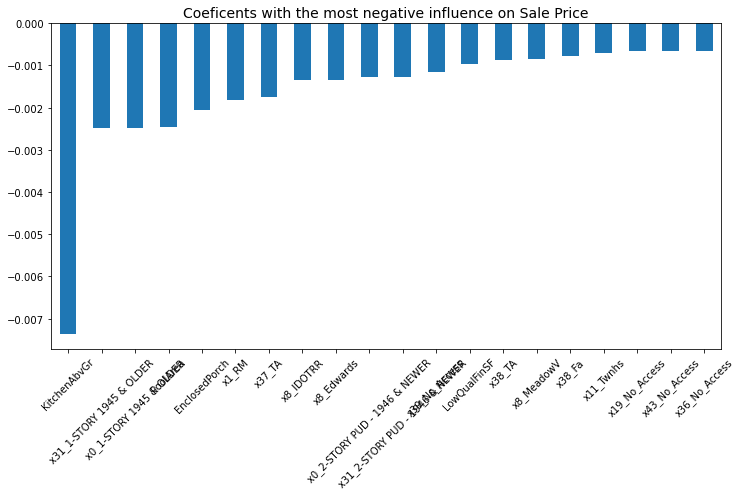

In [15]:
plt.figure(figsize=(12,6))
plt.title('Coeficents with the most negative influence on Sale Price',fontsize=14)
sgd_coef_df['Model Coefs'].sort_values()[0:20].plot(kind='bar');
plt.xticks(rotation=45);

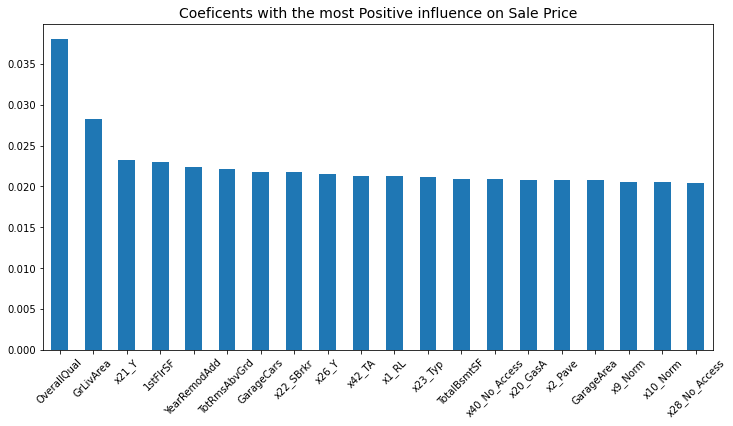

In [16]:
plt.figure(figsize=(12,6))
plt.title('Coeficents with the most Positive influence on Sale Price',fontsize=14)
sgd_coef_df['Model Coefs'].sort_values(ascending=False)[0:20].plot(kind='bar');
plt.xticks(rotation=45);

In [17]:
sgd_pred = model.predict(drop_train_X)

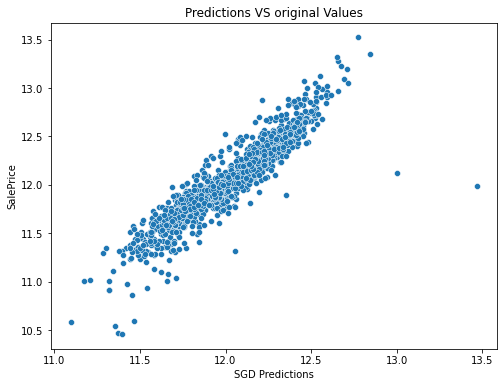

In [18]:
plt.figure(figsize=(8,6));
sns.scatterplot(sgd_pred, drop_train_y);
plt.xlabel('SGD Predictions');
plt.title('Predictions VS original Values');

### There are 2 predictions from our Regressor which seem extreme and should be further Inevstigated

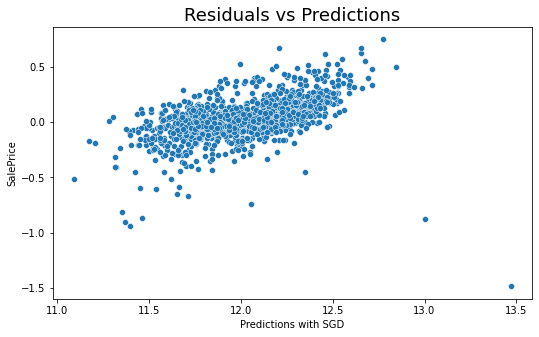

In [19]:
plt.figure(figsize=(8.6,5));
residuals = drop_train_y - sgd_pred
sns.scatterplot(x=sgd_pred,y=residuals);
plt.xlabel('Predictions with SGD');
plt.title('Residuals vs Predictions', fontsize=18);

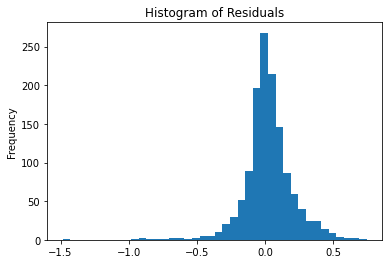

In [20]:
residuals.plot(kind='hist',bins=40);
plt.title('Histogram of Residuals');

#### Seems likely that  the extreme examples are the outliers found during the EDA - which should be investigated further and these examples should most probably be deleted

In [21]:
ordinal_train_X.drop(index=[1298,523],inplace=True)
ordinal_train_y.drop(index=[1298,523],inplace=True)
drop_train_X.drop(index=[1298,523],inplace=True)
drop_train_y.drop(index=[1298,523],inplace=True)
full_train_X.drop(index=[1298,523],inplace=True)
full_train_y.drop(index=[1298,523],inplace=True)

In [22]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty': ('l1','l2'), 'alpha': np.linspace(0.01,5,10)}
sgd = SGDRegressor(loss='squared_loss')
gridsearch = GridSearchCV(sgd,parameters,cv=10,scoring='neg_mean_squared_error')
gridsearch.fit(drop_train_X,drop_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.381147146201512 {'alpha': 0.01, 'penalty': 'l1'}
0.33451362595534107 {'alpha': 0.01, 'penalty': 'l2'}
0.3992281579920637 {'alpha': 0.5644444444444445, 'penalty': 'l1'}
0.21770022938023226 {'alpha': 0.5644444444444445, 'penalty': 'l2'}
0.3991862988891874 {'alpha': 1.118888888888889, 'penalty': 'l1'}
0.17894412971313015 {'alpha': 1.118888888888889, 'penalty': 'l2'}
0.39908770034992286 {'alpha': 1.6733333333333336, 'penalty': 'l1'}
0.17087597849687772 {'alpha': 1.6733333333333336, 'penalty': 'l2'}
0.39925504708747006 {'alpha': 2.227777777777778, 'penalty': 'l1'}
0.17039160541061396 {'alpha': 2.227777777777778, 'penalty': 'l2'}
0.3992352890160169 {'alpha': 2.7822222222222224, 'penalty': 'l1'}
0.1808701299451273 {'alpha': 2.7822222222222224, 'penalty': 'l2'}
0.39911879476866824 {'alpha': 3.336666666666667, 'penalty': 'l1'}
0.1872272294253303 {'alpha': 3.336666666666667, 'penalty': 'l2'}
0.3991812142037668 {'alpha': 3.8911111111111114, 'penalty': 'l1'}
0.19290306416467182 {'alpha': 3.89111

In [23]:
sgd = SGDRegressor(penalty='l2', alpha=1.8,loss='squared_loss')
scores_optimal = cross_val_score(sgd, drop_train_X,drop_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),4))

Average Prediction Mistake for Ordinal Dataset:  0.1677


### The optimzed CV SGD results in around 0.176 RMSE

## Support Vector Regressor

In [24]:
from sklearn.svm import SVR
svr = SVR(max_iter=20000)
scores_optimal = cross_val_score(svr, ordinal_train_X,ordinal_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.13


In [25]:
parameters = {'kernel': ('linear','rbf'), 'C': [0.01,1,10,100]}
gridsearch = GridSearchCV(svr,parameters,cv=5,scoring='neg_mean_squared_error')
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.11632129738727799 {'C': 0.01, 'kernel': 'linear'}
0.2313195511880617 {'C': 0.01, 'kernel': 'rbf'}
0.14231646878201282 {'C': 1, 'kernel': 'linear'}
0.14485778279351083 {'C': 1, 'kernel': 'rbf'}
0.1654026748481295 {'C': 10, 'kernel': 'linear'}
0.1475985208968091 {'C': 10, 'kernel': 'rbf'}
0.18913384336625522 {'C': 100, 'kernel': 'linear'}
0.1475985208968091 {'C': 100, 'kernel': 'rbf'}


In [65]:
svr = SVR(kernel='linear',max_iter=10000)
parameters = {'C': np.linspace(0.01,1,5),'epsilon': np.linspace(0.01,0.3,5)}
gridsearch = GridSearchCV(svr,parameters,cv=10,scoring='neg_mean_squared_error')
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.1140225473038832 {'C': 0.01, 'epsilon': 0.01}
0.11410407061011459 {'C': 0.01, 'epsilon': 0.08249999999999999}
0.11972535664485247 {'C': 0.01, 'epsilon': 0.155}
0.13073237206335397 {'C': 0.01, 'epsilon': 0.22749999999999998}
0.14803174220585627 {'C': 0.01, 'epsilon': 0.3}
0.12562361529904048 {'C': 0.2575, 'epsilon': 0.01}
0.1261081010561993 {'C': 0.2575, 'epsilon': 0.08249999999999999}
0.1357728862652867 {'C': 0.2575, 'epsilon': 0.155}
0.14910284129644258 {'C': 0.2575, 'epsilon': 0.22749999999999998}
0.15484693884603162 {'C': 0.2575, 'epsilon': 0.3}
0.13323643904210167 {'C': 0.505, 'epsilon': 0.01}
0.13275975317381042 {'C': 0.505, 'epsilon': 0.08249999999999999}
0.14231528217239564 {'C': 0.505, 'epsilon': 0.155}
0.15461290736354094 {'C': 0.505, 'epsilon': 0.22749999999999998}
0.15484693884603162 {'C': 0.505, 'epsilon': 0.3}
0.14189274859095083 {'C': 0.7525, 'epsilon': 0.01}
0.13748725570862805 {'C': 0.7525, 'epsilon': 0.08249999999999999}
0.14707764615740512 {'C': 0.7525, 'epsilon': 0

In [27]:
from sklearn.svm import SVR
svr = SVR(kernel='linear', C=0.01,max_iter=10000)
scores_optimal = cross_val_score(svr, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),4))

Average Prediction Mistake for Ordinal Dataset:  0.1152


In [67]:
svr = SVR(kernel='linear', C=0.01,max_iter=20000,epsilon=0.01)
model = svr.fit(full_train_X,full_train_y)

In [68]:
svr_coef_df = pd.DataFrame(data=model.coef_.T,index=full.columns[:-1],columns=['Model Coefs'])

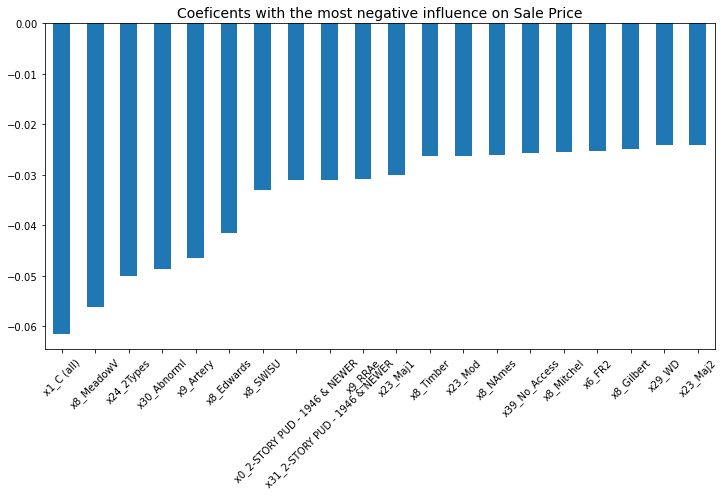

In [69]:
plt.figure(figsize=(12,6))
plt.title('Coeficents with the most negative influence on Sale Price',fontsize=14)
svr_coef_df['Model Coefs'].sort_values()[0:20].plot(kind='bar');
plt.xticks(rotation=45);

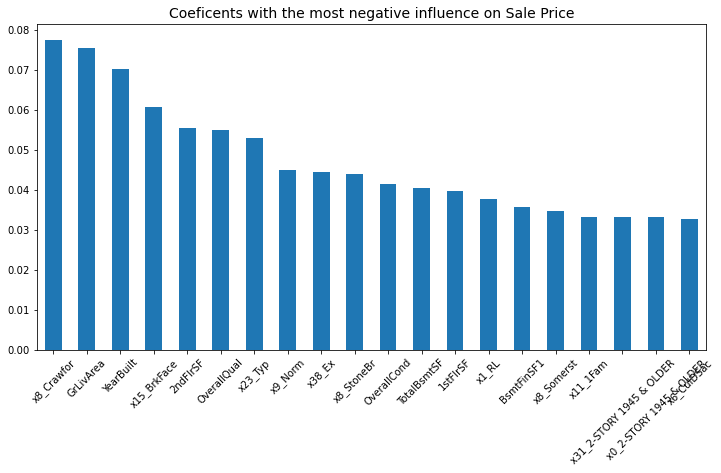

In [70]:
plt.figure(figsize=(12,6))
plt.title('Coeficents with the most negative influence on Sale Price',fontsize=14)
svr_coef_df['Model Coefs'].sort_values(ascending=False)[0:20].plot(kind='bar');
plt.xticks(rotation=45);

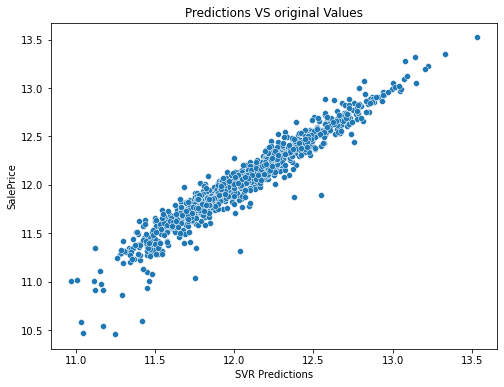

In [71]:
svr_pred = svr.predict(full_train_X)
plt.figure(figsize=(8,6));
sns.scatterplot(svr_pred, full_train_y);
plt.xlabel('SVR Predictions');
plt.title('Predictions VS original Values');

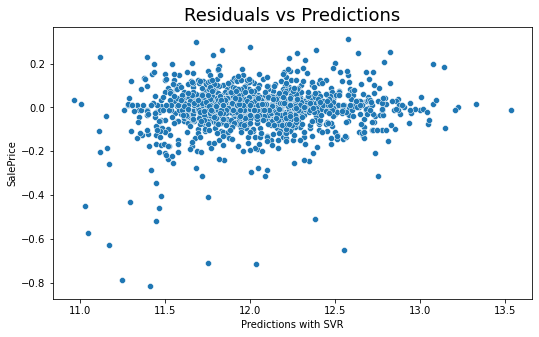

In [72]:
plt.figure(figsize=(8.6,5));
residuals = drop_train_y - svr_pred
sns.scatterplot(x=svr_pred,y=residuals);
plt.xlabel('Predictions with SVR');
plt.title('Residuals vs Predictions', fontsize=18);

### The optimzed CV SVR result is around 0.111 RMSE

## Decision Trees


In [34]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
scores_optimal = cross_val_score(tree_reg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.2


In [35]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
parameters = {'max_depth': np.linspace(10,100,10),'min_samples_split': [20,40,60,100],'min_samples_leaf': [6,12,18,14],'max_features': ('auto','sqrt','log2')}
gridsearch = GridSearchCV(tree_reg,parameters,cv=10,scoring='neg_mean_squared_error')
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.189997466754775 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 20}
0.18741878310197388 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 40}
0.18494823948206093 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 60}
0.19560025182007454 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 100}
0.1830844156454014 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 20}
0.1857271840343041 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 40}
0.1844435984467705 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 60}
0.19747315111676905 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 12, 'min_samples_split': 100}
0.1848272042281909 {'max_depth': 10.0, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_spl

In [36]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=80)
parameters = {'min_samples_split': [4,12,16,20],'min_samples_leaf': [18,24,36]}
gridsearch = GridSearchCV(tree_reg,parameters,cv=10,scoring='neg_mean_squared_error')
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.18460669540408556 {'min_samples_leaf': 18, 'min_samples_split': 4}
0.18440561185075682 {'min_samples_leaf': 18, 'min_samples_split': 12}
0.1844155140878705 {'min_samples_leaf': 18, 'min_samples_split': 16}
0.18462997419883168 {'min_samples_leaf': 18, 'min_samples_split': 20}
0.18306061740770757 {'min_samples_leaf': 24, 'min_samples_split': 4}
0.1830918923455349 {'min_samples_leaf': 24, 'min_samples_split': 12}
0.1830606174077075 {'min_samples_leaf': 24, 'min_samples_split': 16}
0.18306061740770765 {'min_samples_leaf': 24, 'min_samples_split': 20}
0.19115805250959203 {'min_samples_leaf': 36, 'min_samples_split': 4}
0.19115805250959209 {'min_samples_leaf': 36, 'min_samples_split': 12}
0.19115805250959203 {'min_samples_leaf': 36, 'min_samples_split': 16}
0.19115805250959206 {'min_samples_leaf': 36, 'min_samples_split': 20}


In [37]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=80,min_samples_leaf=24)
scores_optimal = cross_val_score(tree_reg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.18


In [38]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
scores_optimal = cross_val_score(forest_reg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.14


In [39]:
parameters = {'min_samples_split': [2,6,12],'min_samples_leaf': [6,12,18],'n_estimators': [50,100,200]}
gridsearch = GridSearchCV(forest_reg,parameters,cv=10,scoring='neg_mean_squared_error')
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.14290785212031104 {'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50}
0.1424149400802051 {'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
0.14244293482950024 {'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 200}
0.14349105291833641 {'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 50}
0.142870387553922 {'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}
0.1427810002751506 {'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 200}
0.14344457314827438 {'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 50}
0.14281676440326818 {'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 100}
0.14245480954838474 {'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 200}
0.14966202402056844 {'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 50}
0.15020533473239425 {'min_samples_leaf': 12, 'min_samples_split': 2, 'n_estimators': 100}
0.1499932769247099 {'min

In [40]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(min_samples_leaf=6,min_samples_split=2, n_estimators=1000)
scores_optimal = cross_val_score(forest_reg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),4))

Average Prediction Mistake for Ordinal Dataset:  0.1423


### GradientBoostingRegressor

In [41]:
from sklearn.ensemble import GradientBoostingRegressor 
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=300, learning_rate=0.1)
scores_optimal = cross_val_score(gbrt, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.12


In [42]:
gbrt = GradientBoostingRegressor(min_samples_split=8,min_samples_leaf=3,max_depth=5,max_features='sqrt',subsample=0.8)
parameters = {'n_estimators': range(20,81,10)}
gridsearch = GridSearchCV(gbrt,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.16662215744718634 {'n_estimators': 20}
0.1441860836765436 {'n_estimators': 30}
0.13082494770086128 {'n_estimators': 40}
0.13078006564644493 {'n_estimators': 50}
0.1263154869468408 {'n_estimators': 60}
0.121300860078398 {'n_estimators': 70}
0.12410218235912526 {'n_estimators': 80}


In [43]:
gbrt = GradientBoostingRegressor(n_estimators=70,learning_rate=0.1,max_features='sqrt',subsample=0.8)
parameters = {'max_depth':range(2,16,2), 'min_samples_split':range(3,30,3)}
gridsearch = GridSearchCV(gbrt,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.14133681100532072 {'max_depth': 2, 'min_samples_split': 3}
0.139696371236817 {'max_depth': 2, 'min_samples_split': 6}
0.14424307388663693 {'max_depth': 2, 'min_samples_split': 9}
0.14286240705963074 {'max_depth': 2, 'min_samples_split': 12}
0.1414692938676276 {'max_depth': 2, 'min_samples_split': 15}
0.14381546498995085 {'max_depth': 2, 'min_samples_split': 18}
0.14240183795887523 {'max_depth': 2, 'min_samples_split': 21}
0.14084125275341314 {'max_depth': 2, 'min_samples_split': 24}
0.14120040262369216 {'max_depth': 2, 'min_samples_split': 27}
0.1266783748809799 {'max_depth': 4, 'min_samples_split': 3}
0.12738264326895563 {'max_depth': 4, 'min_samples_split': 6}
0.1272405272028668 {'max_depth': 4, 'min_samples_split': 9}
0.12551106859278463 {'max_depth': 4, 'min_samples_split': 12}
0.12721066765413044 {'max_depth': 4, 'min_samples_split': 15}
0.12883678966626821 {'max_depth': 4, 'min_samples_split': 18}
0.12633985301766168 {'max_depth': 4, 'min_samples_split': 21}
0.12787813214025284

In [44]:
gbrt = GradientBoostingRegressor(n_estimators=60,learning_rate=0.1,subsample=0.8,max_depth=6,min_samples_split=21)
parameters = {'max_features': range(40,80,4)}
gridsearch = GridSearchCV(gbrt,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.122197429633766 {'max_features': 40}
0.12401284162777135 {'max_features': 44}
0.12475397044564182 {'max_features': 48}
0.12084316416032306 {'max_features': 52}
0.12291577340476964 {'max_features': 56}
0.12019396503240874 {'max_features': 60}
0.12433325965937585 {'max_features': 64}
0.12298560153678904 {'max_features': 68}
0.12384839133568658 {'max_features': 72}
0.12231648743969131 {'max_features': 76}


In [45]:
gbrt = GradientBoostingRegressor(n_estimators=60,learning_rate=0.1,max_depth=6,min_samples_split=21,max_features=44)
parameters = {'subsample': np.linspace(0.4,0.8,10)}
gridsearch = GridSearchCV(gbrt,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.1224195637418549 {'subsample': 0.4}
0.12271134028390276 {'subsample': 0.4444444444444445}
0.12340917867387757 {'subsample': 0.48888888888888893}
0.12543395398921184 {'subsample': 0.5333333333333333}
0.12065738479390901 {'subsample': 0.5777777777777778}
0.12289661447543754 {'subsample': 0.6222222222222222}
0.1237961792694137 {'subsample': 0.6666666666666667}
0.11991921470023574 {'subsample': 0.7111111111111111}
0.12153197125658632 {'subsample': 0.7555555555555555}
0.12345323900548175 {'subsample': 0.8}


In [46]:
from sklearn.ensemble import GradientBoostingRegressor 
gbrt = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.03,max_depth=6,min_samples_split=21,max_features=48,subsample=0.8)
scores_optimal = cross_val_score(gbrt, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),4))

Average Prediction Mistake for Ordinal Dataset:  0.1158


In [47]:
model = gbrt.fit(full_train_X,full_train_y)
gbrt_coef_df = pd.DataFrame(data=model.feature_importances_,index=full.columns[:-1],columns=['Model Coefs'])

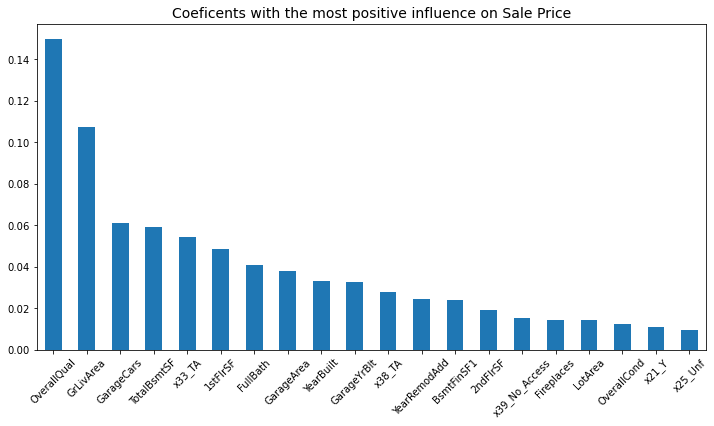

In [48]:
plt.figure(figsize=(12,6))
plt.title('Coeficents with the most positive influence on Sale Price',fontsize=14)
gbrt_coef_df['Model Coefs'].sort_values(ascending=False)[0:20].plot(kind='bar');
plt.xticks(rotation=45);

### WIth Gradient Booster the RMSE seems to be around 0.11 - something to notice is Overal Qual isn't as important here which is a good sign since it isn't clear how this feature has been cosntructed

In [49]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 1000,learning_rate=0.1,subsample=0.8,max_depth=8)

parameters = {}
gridsearch = GridSearchCV(xgb_reg,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)



0.12399872716790858 {}


In [50]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 100,learning_rate=0.1,subsample=0.8)

parameters = {'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)}
gridsearch = GridSearchCV(xgb_reg,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)



0.12263381911436468 {'max_depth': 3, 'min_child_weight': 1}
0.12279753238253528 {'max_depth': 3, 'min_child_weight': 3}
0.12208544418242193 {'max_depth': 3, 'min_child_weight': 5}
0.12269694234060645 {'max_depth': 5, 'min_child_weight': 1}
0.12091893067074348 {'max_depth': 5, 'min_child_weight': 3}
0.12053506919548633 {'max_depth': 5, 'min_child_weight': 5}
0.1235780537710199 {'max_depth': 7, 'min_child_weight': 1}
0.12098139560467724 {'max_depth': 7, 'min_child_weight': 3}
0.12050396131986986 {'max_depth': 7, 'min_child_weight': 5}
0.1245351324159104 {'max_depth': 9, 'min_child_weight': 1}
0.12004352562459795 {'max_depth': 9, 'min_child_weight': 3}
0.12135769755712743 {'max_depth': 9, 'min_child_weight': 5}


In [51]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 100,learning_rate=0.1,subsample=0.8,max_depth=5,min_child_weight=3)

parameters = {'gamma': np.linspace(0.01,1,5)}
gridsearch = GridSearchCV(xgb_reg,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)



0.12094771027915593 {'gamma': 0.01}
0.13053584625369882 {'gamma': 0.2575}
0.13815849780441586 {'gamma': 0.505}
0.14603540651975372 {'gamma': 0.7525}
0.15001405952187777 {'gamma': 1.0}


In [52]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 1000,learning_rate=0.1,subsample=0.8,max_depth=5,min_child_weight=3)
scores_optimal = cross_val_score(xgb_reg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),2))

Average Prediction Mistake for Ordinal Dataset:  0.12


In [53]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 200,learning_rate=0.1,max_depth=5,min_child_weight=3)

parameters = { 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}
gridsearch = GridSearchCV(xgb_reg,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)



0.12043826191139603 {'colsample_bytree': 0.6, 'subsample': 0.6}
0.11862703151848558 {'colsample_bytree': 0.6, 'subsample': 0.7}
0.12005494428713004 {'colsample_bytree': 0.6, 'subsample': 0.8}
0.11769324367974907 {'colsample_bytree': 0.6, 'subsample': 0.9}
0.11915511366508211 {'colsample_bytree': 0.7, 'subsample': 0.6}
0.12004255481404727 {'colsample_bytree': 0.7, 'subsample': 0.7}
0.11978321982680153 {'colsample_bytree': 0.7, 'subsample': 0.8}
0.11801924917248138 {'colsample_bytree': 0.7, 'subsample': 0.9}
0.11934755854564585 {'colsample_bytree': 0.8, 'subsample': 0.6}
0.12001912686914015 {'colsample_bytree': 0.8, 'subsample': 0.7}
0.11780746192357323 {'colsample_bytree': 0.8, 'subsample': 0.8}
0.1200360474306049 {'colsample_bytree': 0.8, 'subsample': 0.9}
0.11845585778940877 {'colsample_bytree': 0.9, 'subsample': 0.6}
0.11854520780081446 {'colsample_bytree': 0.9, 'subsample': 0.7}
0.11855439025376603 {'colsample_bytree': 0.9, 'subsample': 0.8}
0.1193780935124464 {'colsample_bytree': 0

In [54]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 200,learning_rate=0.1,max_depth=5,min_child_weight=3,subsample=0.9,colsample_bytree=0.7)

parameters = {'reg_alpha':[0.01,0.1,0.5,1]}
gridsearch = GridSearchCV(xgb_reg,parameters,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)
gridsearch.fit(full_train_X,full_train_y)

cvres = gridsearch.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)



0.12065013595709957 {'reg_alpha': 0.01}
0.11788905172619855 {'reg_alpha': 0.1}
0.11908239617405693 {'reg_alpha': 0.5}
0.12073031724854481 {'reg_alpha': 1}


In [55]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 1000,learning_rate=0.02,max_depth=5,min_child_weight=3,subsample=0.7,colsample_bytree=0.7,reg_alpha=0.2)
scores_optimal = cross_val_score(xgb_reg, full_train_X,full_train_y,scoring='neg_mean_squared_error',cv=10)
print('Average Prediction Mistake for Ordinal Dataset: ', round(np.sqrt(-scores_optimal.mean()),4))

Average Prediction Mistake for Ordinal Dataset:  0.1151


In [56]:
data_dmatrix = xgb.DMatrix(data=full_train_X,label=full_train_y)
params = {'objective':'reg:squarederror',
          'seed': 123,
          'learning_rate':0.02,
          'max_depth':5,
          'min_child_weight':3,
          'subsample':0.7,
          'colsample_bytree':0.7,
          'reg_alpha':0.2
         }

In [57]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, num_boost_round=1000,nfold=10,early_stopping_rounds=50,metrics="rmse", as_pandas=True, seed=123)
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
995,0.038492,0.000674,0.112582,0.017896
996,0.038459,0.000674,0.112578,0.017897
997,0.038416,0.000674,0.112579,0.017899
998,0.038381,0.000669,0.112575,0.017899
999,0.038346,0.000674,0.112576,0.017895


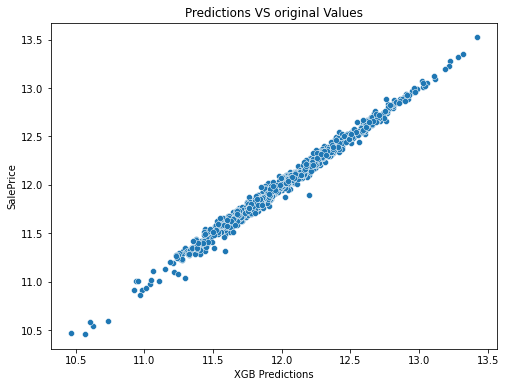

In [58]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 1000,learning_rate=0.02,max_depth=5,min_child_weight=3,subsample=0.7,colsample_bytree=0.7,reg_alpha=0.2)
xgb_reg.fit(full_train_X,full_train_y)
xgb_pred = xgb_reg.predict(full_train_X)
plt.figure(figsize=(8,6));
sns.scatterplot(xgb_pred, full_train_y);
plt.xlabel('XGB Predictions');
plt.title('Predictions VS original Values');

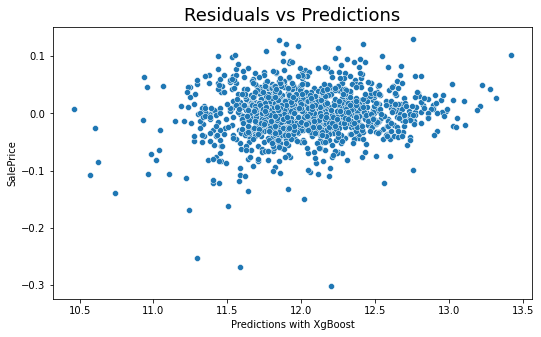

In [59]:
plt.figure(figsize=(8.6,5));
residuals = drop_train_y - xgb_pred
sns.scatterplot(x=xgb_pred,y=residuals);
plt.xlabel('Predictions with XgBoost');
plt.title('Residuals vs Predictions', fontsize=18);

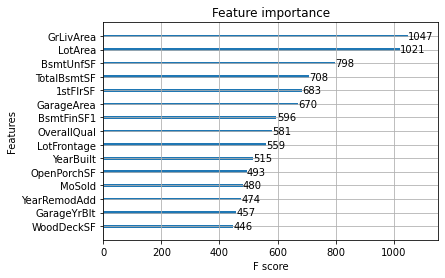

In [60]:
from xgboost import plot_importance,plot_tree
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 1000,learning_rate=0.02,max_depth=5,min_child_weight=3,subsample=0.7,colsample_bytree=0.7,reg_alpha=0.2)
xgb_reg.fit(full_train_X,full_train_y)
plot_importance(xgb_reg,max_num_features=15);

#### By feature improtance it should be understood the number of times a feature appears in a tree - Therefore numerical features are more likely to be more prevalent here

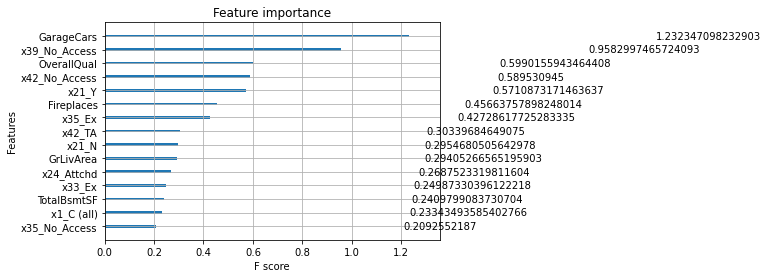

In [61]:
#xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',seed = 123,n_estimators = 1000,learning_rate=0.02,max_depth=5,min_child_weight=3,subsample=0.7,colsample_bytree=0.7,reg_alpha=0.2)
#xgb_reg.fit(full_train_X,full_train_y)
plot_importance(xgb_reg,max_num_features=15,importance_type='gain');

#### By contrast this chart shows feature importance - by gain on a split. Here categorical values should be more prevalent

#### A postive trend is that with XGBoost the reliance on OveralQual column seems to be less significant

In [73]:
svr_pred = svr.predict(full_test_x)
print('Validation Error with SVR is: ', np.sqrt(mean_squared_error(svr_pred,full_test_y)))

Validation Error with SVR is:  0.11098406269218021


In [63]:
gbrt_pred = gbrt.predict(full_test_x)
print('Validation Error with Gradient Boosting Regressor is: ', np.sqrt(mean_squared_error(gbrt_pred,full_test_y)))

Validation Error with Gradient Boosting Regressor is:  0.12571669087076418


In [64]:
xgb_pred = xgb_reg.predict(full_test_x)
print('Validation Error with XGBoost is: ', np.sqrt(mean_squared_error(xgb_pred,full_test_y)))

Validation Error with XGBoost is:  0.12569793305593568


#### SVR gives us the model with the lowest Bias and Variance - although colleting more data and testing the model even more would have been more optimal. 

#### There are a few Skewed features and outliers which could also be explored to further improve the model. 

#### Combining future predictions is also a viable next part